In [1]:
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Activation, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from util import *
from loadFrey import *

c:\users\user\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 50
sizeBatch = 16
sizeKernel = 3
dimInter = 256
dimEncode = 64
layer_filters = [32, 64]
stdEps = 1.0 
ratRecon = 0.9999
factNoise = 0
nameOptim = 'adam'

## Load the datasets

In [3]:
xTrain, xTest = load_frey_face_dataset()
sizeDigit = xTrain.shape[1:]
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])

xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.

xTrain = np.reshape(xTrain, [-1, *sizeDigit, 1])
xTest = np.reshape(xTest, [-1, *sizeDigit, 1])
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(1400, 28, 20, 1)
(565, 28, 20, 1)


## Construct the encoder and decoder

In [4]:
inputs = Input(shape=(*sizeDigit, 1))  # adapt this if using `channels_first` image data format
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=sizeKernel,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
x = Dense(dimInter, activation='relu')(x)
zMean = Dense(dimEncode)(x)
zSigmaLog = Dense(dimEncode)(x) # log for linear dense

def sampling(args):
    zMean, zSigmaLog = args
    epsilon = K.random_normal(shape=(K.shape(zMean)[0], dimEncode),
                              mean=0., stddev=stdEps)
    return zMean + K.exp(zSigmaLog) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Lambda(sampling)([zMean, zSigmaLog])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

# Build the Decoder Model
inputLatent = Input(shape=(dimEncode,), name='decoder_input')
x = Dense(dimInter, activation='relu')(inputLatent)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=sizeKernel,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=sizeKernel,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(inputLatent, outputs, name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 10, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 5, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2240)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

## Construct the autoencoder

In [5]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 20, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 64)                625408    
_________________________________________________________________
decoder (Model)              (None, 28, 20, 1)         648001    
Total params: 1,273,409
Trainable params: 1,273,409
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
def lossVAE(zMean, zSigmaLog):
    def loss(tensorInput, tensorDecode):
        lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
        lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    return loss

autoencoder.compile(optimizer=nameOptim, loss=lossVAE(zMean, zSigmaLog))

# Train the autoencoder
tic = time()
history = autoencoder.fit(xTrainNoise, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 1400 samples, validate on 565 samples
Epoch 1/50
1400/1400 [==============================] - 4s 3ms/step - loss: 0.0993 - val_loss: 0.0315
Epoch 2/50
1400/1400 [==============================] - 1s 788us/step - loss: 0.0224 - val_loss: 0.0193
Epoch 3/50
1400/1400 [==============================] - 1s 777us/step - loss: 0.0185 - val_loss: 0.0178
Epoch 4/50
1400/1400 [==============================] - 1s 747us/step - loss: 0.0177 - val_loss: 0.0174
Epoch 5/50
1400/1400 [==============================] - 1s 753us/step - loss: 0.0174 - val_loss: 0.0172
Epoch 6/50
1400/1400 [==============================] - 1s 815us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 7/50
1400/1400 [==============================] - 1s 749us/step - loss: 0.0171 - val_loss: 0.0171
Epoch 8/50
1400/1400 [==============================] - 1s 748us/step - loss: 0.0171 - val_loss: 0.0170
Epoch 9/50
1400/1400 [==============================] - 1s 778us/step - loss: 0.0171 - val_loss: 0.0170
Epoch 10/50
1400/14

## Show the historical training progress 

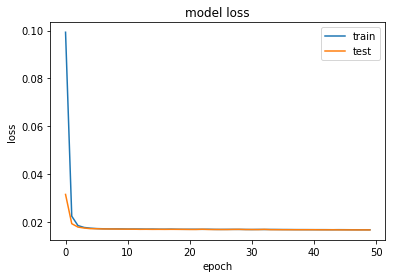

In [7]:
# print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTestNoise)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

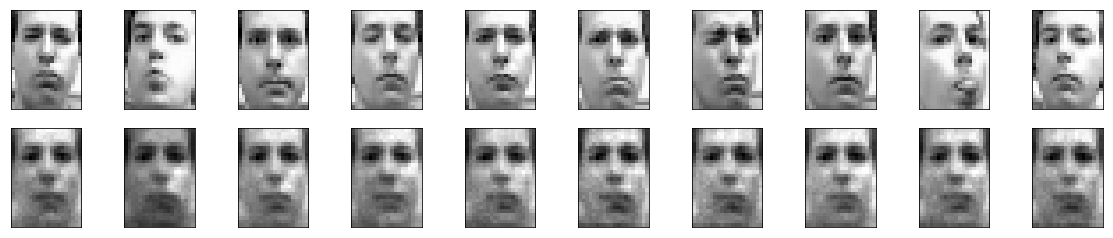

In [9]:
plotCompDecode(xTest, decodeTest, sizeReshape = sizeDigit)

## Plot the scatter of the encoding space

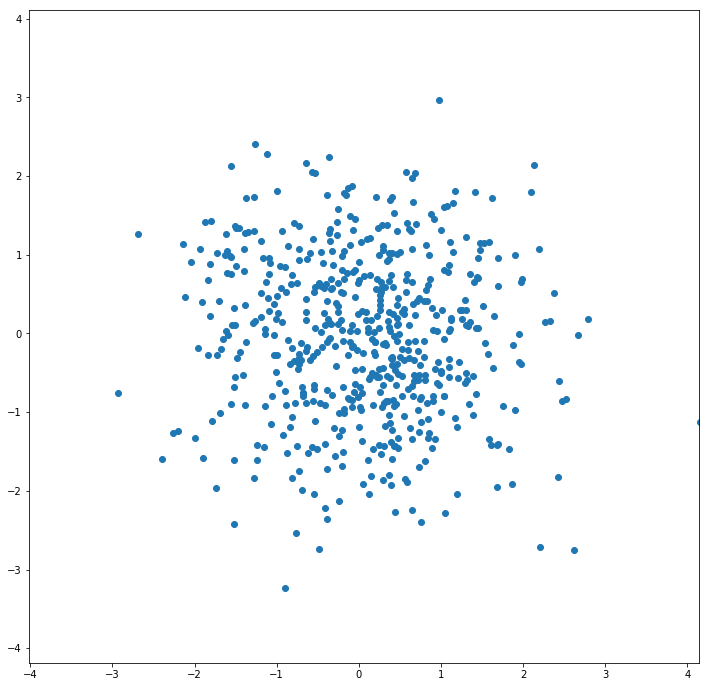

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, None, xlim, ylim, numShow=10000)
# scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

In [11]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, sizeDigit, xlim, ylim)

ValueError: Error when checking : expected decoder_input to have shape (64,) but got array with shape (2,)

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1])

In [ ]:
xTrain, xTest = load_frey_face_dataset()